### Error Suppression
We can use "optimization_level" to suppress errors in primitives. Let us observe different optimization levels and their behaviour.

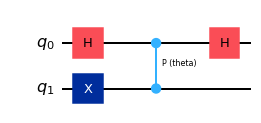

In [3]:
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

theta = Parameter("theta")
qc = QuantumCircuit(2)
qc.x(1)
qc.h(0)
qc.cp(theta,0,1)
qc.h(0)

observables = SparsePauliOp.from_list([("ZZ", 1)])
qc.draw("mpl")

In [4]:
import numpy as np
phases = np.linspace(0, 2*np.pi, 50)
individual_phases = [[phase] for phase in phases]
print(individual_phases)

[[0.0], [0.1282282715750936], [0.2564565431501872], [0.38468481472528077], [0.5129130863003744], [0.6411413578754679], [0.7693696294505615], [0.8975979010256552], [1.0258261726007487], [1.1540544441758422], [1.2822827157509358], [1.4105109873260295], [1.538739258901123], [1.6669675304762166], [1.7951958020513104], [1.9234240736264039], [2.0516523452014974], [2.179880616776591], [2.3081088883516845], [2.436337159926778], [2.5645654315018716], [2.6927937030769655], [2.821021974652059], [2.9492502462271526], [3.077478517802246], [3.2057067893773397], [3.333935060952433], [3.4621633325275267], [3.5903916041026207], [3.7186198756777142], [3.8468481472528078], [3.9750764188279013], [4.103304690402995], [4.231532961978089], [4.359761233553182], [4.487989505128276], [4.616217776703369], [4.744446048278463], [4.872674319853556], [5.00090259142865], [5.129130863003743], [5.257359134578837], [5.385587406153931], [5.513815677729024], [5.642043949304118], [5.770272220879211], [5.898500492454305], [

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational = True,simulator = False)
backend_sim = AerSimulator.from_backend(backend)

In [6]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
estimator = Estimator(backend_sim)

circuit = qc

# No optimization
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend_sim, optimization_level=0)
isa_circuit = pm.run(circuit)
isa_observable = observables.apply_layout(layout=isa_circuit.layout)

noisy_exp_values = []
pub = (isa_circuit, isa_observable, [individual_phases])
cost = estimator.run([pub]).result()[0].data.evs
noisy_exp_values = cost[0]

In [7]:
# Optimization level 3
pm = generate_preset_pass_manager(backend=backend_sim, optimization_level=3)
isa_circuit = pm.run(circuit)
isa_observable = observables.apply_layout(layout=isa_circuit.layout)

noisy_exp_values_with_opt = []
pub = (isa_circuit, isa_observable, [individual_phases])
cost = estimator.run([pub]).result()[0].data.evs
noisy_exp_values_with_opt = cost[0]

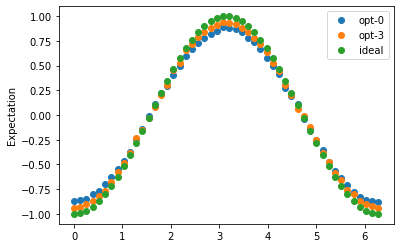

In [8]:
import matplotlib.pyplot as plt

plt.plot(phases, noisy_exp_values, "o", label = "opt-0")

plt.plot(phases, noisy_exp_values_with_opt, "o", label = "opt-3")

plt.plot(phases, 2 * np.sin(phases/2) **2 - 1, "o", label = "ideal")
plt.ylabel("Expectation")
plt.legend()
plt.show()

### Error Mitigation
We reduce circuit errors by modelling that device noise at the time of execution

#### Twirled readout error extinction (T-REx)

Resilience level = 1

In [10]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational = True, simulator = False)

In [11]:
exp_values_with_em0_es = []
exp_values_with_em1_es = []
exp_values_with_em2_es = []

pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
isa_circuit = pm.run(circuit)
isa_observable = observables.apply_layout(layout=isa_circuit.layout)

In [20]:
# No error mitigation

from qiskit_ibm_runtime import Session, Options

with Session(backend=backend) as session:
    session_options = Options()
    estimator = Estimator(mode=backend)
    estimator.options.resilience_level = 0
    estimator.options.default_shots = 10_000

    pub = (isa_circuit, isa_observable, [individual_phases])
    cost = estimator.run([pub]).result()[0].data.evs

session.close()
exp_values_with_em0_es = cost[0]


C:\Users\admin\AppData\Local\Temp/ipykernel_11040/3506639694.py:7: DeprecationWarning: Passing a backend as the mode currently runs the job in job mode even if inside of a session/batch context manager. As of qiskit-ibm-runtime version 0.26.0, this behavior is deprecated and in a future release no sooner than than 3 months after the release date, the session/batch will take precendence and the job will not run in job mode. To ensure that jobs are run in session/batch mode, pass in the session/batch or leave the mode parameter emtpy.
  estimator = Estimator(mode=backend)


In [21]:
# resillience 1

with Session(backend=backend) as session:
    session_options = Options()
    estimator = Estimator(mode=backend)
    estimator.options.resilience_level = 1
    estimator.options.default_shots = 10_000

    pub = (isa_circuit, isa_observable, [individual_phases])
    cost = estimator.run([pub]).result()[0].data.evs

session.close()
exp_values_with_em1_es = cost[0]

C:\Users\admin\AppData\Local\Temp/ipykernel_11040/2122818900.py:5: DeprecationWarning: Passing a backend as the mode currently runs the job in job mode even if inside of a session/batch context manager. As of qiskit-ibm-runtime version 0.26.0, this behavior is deprecated and in a future release no sooner than than 3 months after the release date, the session/batch will take precendence and the job will not run in job mode. To ensure that jobs are run in session/batch mode, pass in the session/batch or leave the mode parameter emtpy.
  estimator = Estimator(mode=backend)


In [22]:
# resillience = 2

with Session(backend=backend) as session:
    session_options = Options()
    estimator = Estimator(mode=backend)
    estimator.options.resilience_level = 0
    estimator.options.default_shots = 10_000

    pub = (isa_circuit, isa_observable, [individual_phases])
    cost = estimator.run([pub]).result()[0].data.evs

session.close()
exp_values_with_em2_es = cost[0]


C:\Users\admin\AppData\Local\Temp/ipykernel_11040/4268884144.py:5: DeprecationWarning: Passing a backend as the mode currently runs the job in job mode even if inside of a session/batch context manager. As of qiskit-ibm-runtime version 0.26.0, this behavior is deprecated and in a future release no sooner than than 3 months after the release date, the session/batch will take precendence and the job will not run in job mode. To ensure that jobs are run in session/batch mode, pass in the session/batch or leave the mode parameter emtpy.
  estimator = Estimator(mode=backend)


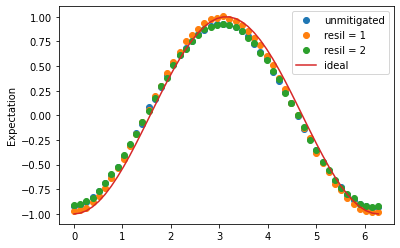

In [23]:
import matplotlib.pyplot as plt

plt.plot(phases, exp_values_with_em0_es, "o", label="unmitigated")
plt.plot(phases, exp_values_with_em1_es, "o", label="resil = 1")
plt.plot(phases, exp_values_with_em2_es, "o", label="resil = 2")
plt.plot(phases, 2 * np.sin(phases / 2) ** 2 - 1, label="ideal")
plt.ylabel("Expectation")
plt.legend()
plt.show()